Função de Transferência 1:


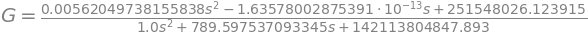

Função de Transferência 2:


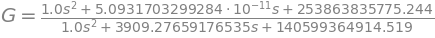

Função de Transferência 3:


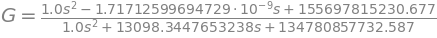

Função de Transferência 4:


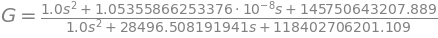

Função de Transferência 5:


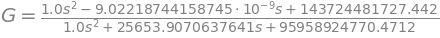

Função de Transferência 6:


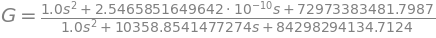

Função de Transferência 7:


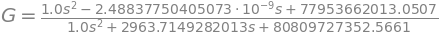

Função de Transferência 8:


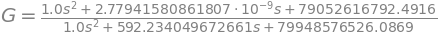

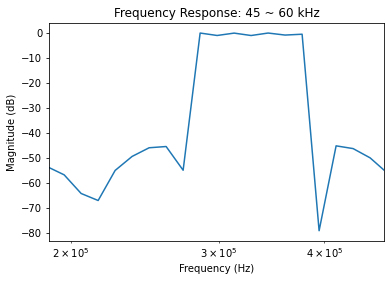

In [2]:
###############################################################################
""" Display the transfer functions """
from IPython.display import display
import sympy as sy

sy.init_printing()  # LaTeX like pretty printing for IPython
pG, pH, pGH, pIGH = sy.symbols("G, H, GH, IGH")  # only needed for displaying

def lti_to_sympy(lsys, symplify=True):
    """ Convert Scipy's LTI instance to Sympy expression """
    s = sy.Symbol('s')
    G = sy.Poly(lsys.num, s) / sy.Poly(lsys.den, s)
    return sy.simplify(G) if symplify else G
###############################################################################

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# Projecting the filter and finding its transfer function
fp1 = np.array([45e3, 60e3]);
fs1 = np.array([44.5e3, 60.5e3]);
wp1 = fp1*2*np.pi
ws1 = fs1*2*np.pi
N1, wn1 = signal.ellipord(wp1, ws1, 1, 45, analog=True);
num1, den1 = signal.ellip(N1, 1, 45, wn1, btype='bandpass', analog=True);
sys = signal.TransferFunction(num1, den1);

# Decomposing the high-order transfer function into cascaded second-order sections
sos = signal.tf2sos(np.array(num1), np.array(den1));
rows, columns = sos.shape;
tf_size = (rows, int(columns/2))

numx = np.zeros(tf_size)
denx = np.zeros(tf_size)
tfs = np.zeros(tf_size) 
tf_res_sy = 1

for row in range(rows):
    numx[row] = sos[row][:3]
    denx[row] = sos[row][3:]
    print(f'Transfer Function {row+1}:')
    tf = lti_to_sympy(signal.TransferFunction(numx[row], denx[row]))
    display(sy.Eq(pG, tf))
    tf_res_sy *= tf

# Plotting the Transfer Function
w, mag, phase = signal.bode(sys)
fig, ax = plt.subplots()
ax.semilogx(w, mag)    # Bode magnitude plot
ax.set_xlim([30e3*2*np.pi, 75e3*2*np.pi])
ax.set(title="Frequency Response: 45 ~ 60 kHz",
       xlabel="Frequency (Hz)",
       ylabel="Magnitude (dB)");

In [3]:
# CHOOSING THE SECOND ORDER SECTION 
""" It's better do it manually, because we can control the results changing the arbitrary values. 
    Usually, the values that we control is 'g1' and 'g2', but you can also change the capacitances. """

num = numx[0]
den = denx[0]


# ARBITRARY VALUES:

# Reference Transconductance 
gar = 1e-5
gfr = 1e-5

# Integrators transconductances 
g1 = 1e-7
g2 = 1e-6

# Integrators capacitances
C1 = 1e-12
C2 = 1e-12

# Integrators - time constants
ctx = [C1/g1, C2/g2]


# USING THE EQUATIONS FOR THE FLF GM-C FILTER:

B2 = np.prod(ctx)  # B2 = ct1*ct2
Ai = np.zeros(3)   # Ai = [A0, A1, A2]
Bi = np.zeros(3)   # Bi = [B0, B1, B2]

for i in range (3):
    Ai[i] = B2 * num[2-i]
    Bi[i] = B2 * den[2-i]

# Upper transconductances
fi = np.zeros(2)   # [f1, f2]
gfi = np.zeros(2)  # [gf1, gf2]

# Lower transconductances
ai = np.zeros(3)   # [a0, a1, a2]
gai = np.zeros(3)  # [ga0, ga1, ga2]

fi[0] = Bi[1]/ctx[1]                # f1 = B1/ct2
fi[1] = Bi[0]                       # f2 = B0
ai[0] = Ai[2]/np.prod(ctx)          # a0 = A2/(ct1*ct2)
ai[1] = Ai[1]/ctx[1] - ai[0]*fi[0]  # a1 = A1/ct2 - a0*f1 
ai[2] = Ai[0] - ai[0]*fi[1]         # a2 = A0 - a0*f2

for i in range(len(ai)):
    gai[i] = ai[i]*gar
    
for i in range(len(fi)):
    gfi[i] = fi[i]*gfr

print("Upper transconductances:")
print(f"gf1: {gfi[0]} || gf2: {gfi[1]}\n")
print("Lower transconductances:")
print(f"ga0: {gai[0]} || ga1: {gai[1]} || ga2: {gai[2]}")

Upper transconductances:
gf1: 7.895975370933448e-08 || gf2: 1.4211380484789273e-05

Lower transconductances:
ga0: 5.620497381558376e-08 || ga1: -4.4379308897182503e-10 || ga2: -5.472022419069639e-08
